In [220]:
import os
import pandas as pd
from pymongo import MongoClient
import numpy as np
import scipy.stats as stats
import seaborn as sns

pd.set_option('max_colwidth', 90)
pd.set_option('max_rows', 100)

In [294]:
def get_db_object():
    """
    """
    MONGO_URI = os.getenv("MONGO_URI")
    MONGO_DATABASE = "DJs_v7"

    client = MongoClient(MONGO_URI)
    db = client[MONGO_DATABASE]
    return db


def get_top_10_relatores():
    MONGO_URI = os.getenv("MONGO_URI")
    MONGO_DATABASE = os.getenv("MONGO_DATABASE")
    client = MongoClient(MONGO_URI)
    db = client[MONGO_DATABASE]
    docs = db["acordaos"].aggregate(
        [
            {"$group": {"_id": "$relator", "count": {"$sum": 1}}},
            {"$sort": {"count": -1}},
            {"$limit": 10},
        ]
    )
    relatores = [doc["_id"] for doc in docs]

    return relatores


def get_decisions_collection_kleinberg(db, collection_name, sortby="authority"):
    """
    """
    page_ranks_iters = []
    selected_keys = {"acordaoId": 1, "authority": 1, "hub": 1, "relator": 1}
    df_collection = pd.DataFrame()
    for i in range(1, 11):
        coll_name_iter_i = collection_name + "_%d" % i
        page_ranks_cursor = (
            db[coll_name_iter_i]
            .find({}, selected_keys)
            .sort([(sortby, -1)])
            .limit(100)
        )
        df = pd.DataFrame(page_ranks_cursor)
        df["collection_iter"] = i
        df.drop("_id", axis=1, inplace=True)
        df_collection = df_collection.append(df)

    return df_collection


def get_decisions_collection(db, collection_name):
    """
    """
    page_ranks_iters = []
    selected_keys = {"acordaoId": 1, "pageRank": 1, "relator": 1}
    df_collection = pd.DataFrame()
    for i in range(1, 11):
        coll_name_iter_i = collection_name + "_%d" % i
        page_ranks_cursor = (
            db[coll_name_iter_i]
            .find({}, selected_keys)
            .sort([("pageRank", -1)])
            .limit(100)
        )
        df = pd.DataFrame(page_ranks_cursor)
        df["collection_iter"] = i
        df.drop("_id", axis=1, inplace=True)
        df_collection = df_collection.append(df)

    return df_collection


def get_decisions_dataframes_tabulated_kleinberg(db, coll_name, perturbances):
    """
    """
    coll_names = []
    for perturbance in perturbances:
        coll_names.append(coll_name.format(perturbance))

    df_lst = []
    for i, perturbance in enumerate(perturbances):
        df_lst.append(get_decisions_collection_kleinberg(db, coll_names[i]))

    return df_lst


def get_decisions_dataframes_tabulated(db, coll_name, perturbances, pr_models):
    """
    """
    coll_names = []
    for perturbance in perturbances:
        pr_models_coll_names = []
        for pr_model in pr_models:
            pr_models_coll_names.append(coll_name.format(pr_model, perturbance))
        coll_names.append(pr_models_coll_names)

    df_lst = []
    for i, perturbance in enumerate(perturbances):
        pr_models_dfs = []
        for j, pr_model in enumerate(pr_models):
            pr_models_dfs.append(get_decisions_collection(db, coll_names[i][j]))
        df_lst.append(pr_models_dfs)

    return df_lst


def get_top_10_magistrates(df_magistrates_decs_lst):
    """
    """
    top_10_magistrates = []
    for df_magistrates_decs_pr_models in df_magistrates_decs_lst:
        relatores = df_magistrates_decs_pr_models["relator"].value_counts().index
        relatores = relatores[relatores != ""]
        top_10_magistrates.append(relatores[0])

    return top_10_magistrates


def get_number_of_decisions_with_without_similars(db, coll_name, relatores=None):
    """
    """
    with_without_similars_sizes = []
    if relatores:
        for i, relator in enumerate(relatores):
            with_without_similars_sizes.append([i + 1, relator, db[coll_name.format(i+1)].find({}).count(), db["acordaos"].find({"relator": {"$eq": relator}}).count()])
        with_without_similars_sizes = sorted(with_without_similars_sizes, reverse=True, key=lambda x: x[3])
    else:
        with_without_similars_sizes.extend([db[coll_name].find({}).count(), db["acordaos"].find({}).count()])

    return with_without_similars_sizes


def get_decisions_in_at_least_8_iters_of_10(df_collection):
    """
    """
    df_collection_ids = df_collection["acordaoId"].value_counts()
    df_ids_in_8_to_10_iters = df_collection_ids[
                                        df_collection_ids >= 8
                                               ].reset_index()
    df_ids_in_8_to_10_iters.drop("acordaoId", axis=1, inplace=True)
    df_ids_in_8_to_10_iters = df_ids_in_8_to_10_iters.rename(
        columns={"index": "acordaoId"}
    )
    df_ids_in_8_to_10_iters = df_collection[
        df_collection["acordaoId"].isin(
            df_ids_in_8_to_10_iters["acordaoId"]
        )
    ].drop_duplicates("acordaoId")
    return df_ids_in_8_to_10_iters


def get_network_robutness_tabulated_kleinberg(df_perturbations):
    """
    """
    df_robustness_lst = []
    for df_perturbation in df_perturbations:
        df_robustness_lst.append(
            [get_decisions_in_at_least_8_iters_of_10(df_perturbation)]
        )

    return df_robustness_lst


def get_network_robutness_tabulated(df_perturbations):
    """
    """
    df_robustness_lst = []
    for df_perturbation in df_perturbations:
        df_perturbation_lst = []
        for df_pr_model in df_perturbation:
            df_perturbation_lst.append(
                get_decisions_in_at_least_8_iters_of_10(df_pr_model)
            )
        df_robustness_lst.append(df_perturbation_lst)

    return df_robustness_lst


def create_dataframe_from_list_of_list_sizes(dfs_lst, columns, index):
    """
    """
    df = pd.DataFrame(
        [[len(df) for df in dfs] for dfs in dfs_lst], columns=columns, index=index
    )
    return df


def get_intersection_decisions(df1, df2):
    """
    """
    return df1[df1["acordaoId"].isin(df2["acordaoId"])]


def get_intersection_decisions_first_iter(df1, df2):
    """
    """
    df1_iter1 = df1[df1["collection_iter"] == 1]
    df2_iter1 = df2[df2["collection_iter"] == 1]

    df_intersection_decs = get_intersection_decisions(df1_iter1, df2_iter1)
    df_intersection_decs.drop("collection_iter", axis=1, inplace=True)
    return df_intersection_decs


def get_intersection_decisions_first_iter_tabulated(df_perturbations):
    """
    """
    df_intersect_lst = []
    for df_perturbation in df_perturbations:
        df_intersect_lst.append(get_intersection_decisions_first_iter(*df_perturbation))

    return df_intersect_lst


def create_dataframe_from_list_sizes(dfs, columns, index):
    """
    """
    df = pd.DataFrame([len(df) for df in dfs], columns=columns, index=index)
    return df


def get_intersection_decisions_tabulated(df_perturbations):
    """
    """
    df_intersect_lst = []
    for df_perturbation in df_perturbations:
        df_intersect_lst.append(get_intersection_decisions(*df_perturbation))

    return df_intersect_lst


def get_absent_magistrates(df_perturbance_lst, top_10_magistrates):
    absent_relator_perturbances = []
    for df_perturbance in df_perturbance_lst:
        absent_relator_pr_models = []
        for pr_model in df_perturbance:
            absent_relator_pr_models.append(list(set(top_10_magistrates) - set(pr_model[pr_model["relator"].isin(top_10_magistrates)]["relator"])))
        absent_relator_perturbances.append(absent_relator_pr_models)

    return absent_relator_perturbances


def calc_qui_square_test(df):
    quisq_test, p_value, dof, _ = stats.chi2_contingency(df.values)

    print(quisq_test, p_value, dof, _)

In [124]:
selected_keys = {"acordaoId": 1, "index": 1, "observacao": 1, "partesTexto": 1,
                 "citacoesObs": 1, "publicacao": 1, "citacoes_revistas": 1, "relator": 1}
page_ranks_cursor = db["acordaos"].find({}, selected_keys)
df = pd.DataFrame(page_ranks_cursor)



### Getting database experiments results and top 10 magistrates which have more decisions for Kleinberg authority

103168 Collegiate decisions (acórdãos) collected from 01/02/2001 until 01/01/2020

In [231]:
db = get_db_object()


df_all_decs_kl_lst = get_decisions_dataframes_tabulated_kleinberg(
    db, "stf_kleinberg_acordaos_{}", [10, 20, 30],
)

df_all_decs_no_similars_kl_lst = get_decisions_dataframes_tabulated_kleinberg(
    db, "stf_kleinberg_acordaos_{}_no_similars", [10],
)

df_magistrates_decs_kl_lst = []
top_magistrates_n = 10
for magistrate_i in range(top_magistrates_n):
    df_magistrates_decs_kl_lst.extend(
        get_decisions_dataframes_tabulated_kleinberg(
            db,
            "stf_kleinberg_acordaos_{}_rel" +\
            "_{mag}".format(mag=magistrate_i + 1),
            [10],
        )
    )

top_10_magistrates = get_top_10_relatores()
# top_10_magistrates = get_top_10_magistrates(df_magistrates_decs_lst)
top_10_magistrates

['MARCO AURÉLIO',
 'CÁRMEN LÚCIA',
 'GILMAR MENDES',
 'RICARDO LEWANDOWSKI',
 'DIAS TOFFOLI',
 'LUIZ FUX',
 'ROSA WEBER',
 'ROBERTO BARROSO',
 'CELSO DE MELLO',
 'ELLEN GRACIE']

### Comparison of number of decisions considering similar decisions and nor considering them

In [232]:
with_without_similars_all_decisions_size = get_number_of_decisions_with_without_similars(db, "stf_kleinberg_acordaos_10_1")
with_without_similars_magistrates_size = get_number_of_decisions_with_without_similars(db, "stf_kleinberg_acordaos_10_rel_{}_1", top_10_magistrates)

In [233]:
df_decisions_with_without_similars_sizes = pd.DataFrame([with_without_similars_all_decisions_size], columns=["with similars", "without_similars"], index=["all decisions"])
df_decisions_with_without_similars_sizes

,with similars,without_similars
all decisions,280506,103168


In [234]:
df_decisions_with_without_similars_magistrates_sizes = pd.DataFrame(sorted([x[1:] for x in with_without_similars_magistrates_size],
                                                                    key=lambda x: x[1], reverse=True),
                                                                    columns=["Magistrate", "with similars", "without_similars"]).set_index("Magistrate")
df_decisions_with_without_similars_magistrates_sizes.sort_values("without_similars", ascending=False)

,with similars,without_similars
Magistrate,,
MARCO AURÉLIO,27130,10732
CÁRMEN LÚCIA,29846,8714
GILMAR MENDES,27991,8392
RICARDO LEWANDOWSKI,22641,6905
DIAS TOFFOLI,23937,6443
LUIZ FUX,17948,6190
ROSA WEBER,17758,6057
ROBERTO BARROSO,15293,5539
CELSO DE MELLO,34145,4622


### Getting kleinberg top 100 decisions data sorted by authority values tabulated for all decisions, for top 10 magistrates, and without similar decisions

In [235]:
df_robustness_kl_lst = get_network_robutness_tabulated_kleinberg(df_all_decs_kl_lst)
df_robustness_no_similars_kl_lst = get_network_robutness_tabulated_kleinberg(
    df_all_decs_no_similars_kl_lst
)
df_robustness_magistrates_kl_lst = get_network_robutness_tabulated_kleinberg(
    df_magistrates_decs_kl_lst
)

### Building robustness tables for Kleinberg top 100 authority nodes (all decisions, top 10 magistrates, and without similar decisions)

In [236]:
df_all_decs_robustness_kl_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_kl_lst, ["aut"], [10, 20, 30]
)
df_no_similars_robustness_kl_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_no_similars_kl_lst, ["aut"], [10]
)
df_magistrates_robustness_kl_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_magistrates_kl_lst, ["aut"], top_10_magistrates
)

### Setting table header for results for all decisions WITH similars

In [237]:
df_all_decs_robustness_kl_table.columns = ["authority"]
df_all_decs_robustness_kl_table.index.name = "Perturbance level (%)"
df_all_decs_robustness_kl_table

,authority
Perturbance level (%),
10,88
20,82
30,58


### Setting table header for results for all decisions WITHOUT similars

In [238]:
df_no_similars_robustness_kl_table.columns = ["authority"]
df_no_similars_robustness_kl_table.index.name = "Perturbance level (%)"
df_no_similars_robustness_kl_table

,authority
Perturbance level (%),
10,92


### Setting table header for results for top 10 magistrates (10% disturbance level) decisions with similar decisions

In [239]:
df_magistrates_robustness_kl_table.columns = ["authority"]
df_magistrates_robustness_kl_table.index.name = "Magistrate"
df_magistrates_robustness_kl_table

,authority
Magistrate,
MARCO AURÉLIO,97
CÁRMEN LÚCIA,46
GILMAR MENDES,18
RICARDO LEWANDOWSKI,63
DIAS TOFFOLI,91
LUIZ FUX,95
ROSA WEBER,95
ROBERTO BARROSO,94
CELSO DE MELLO,101


### Building robustness table for intersection of decisions between Kleinberg authority top 100 for decisions with similar vs decisions without similar decisions

In [240]:
df_robustness_decs_with_similars_vs_without_similars_kl_lst = [
    get_intersection_decisions(
        df_robustness_kl_lst[0][0], df_robustness_no_similars_kl_lst[0][0]
    )
]

df_decs_with_similars_vs_without_similars_robustness_kl_table = create_dataframe_from_list_of_list_sizes(
    [df_robustness_decs_with_similars_vs_without_similars_kl_lst], ["authority"], [10]
)

In [241]:
df_decs_with_similars_vs_without_similars_robustness_kl_table.columns = ["authority"]
df_decs_with_similars_vs_without_similars_robustness_kl_table.index.name = "Perturbance level (%)"
df_decs_with_similars_vs_without_similars_robustness_kl_table

,authority
Perturbance level (%),
10,0


### Getting intersection of Kleinberg authority decisions for iteration 1 between decisions with similar vs decisions without similar decisions

In [242]:
df_intersec_between_with_and_without_sim_kl = get_intersection_decisions_first_iter_tabulated(
    [[df_all_decs_kl_lst[0], df_all_decs_no_similars_kl_lst[0]]]
)

/home/jackson/.local/share/virtualenvs/analise-juridica-SICVn6Yg/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Building robustness table for intersection of decisions between Kleinberg top 100 measure for decisions with similar vs decisions without similar decisions IN THE FIRST ITERATION

In [243]:
df_intersec_between_with_and_without_sim_kl_table = create_dataframe_from_list_sizes(
    df_intersec_between_with_and_without_sim_kl, ["Kleinberg"], [10]
)
df_intersec_between_with_and_without_sim_kl_table

,Kleinberg
10,0


## Decisions best ranked by authority

In [244]:
df_all_decs_kl_lst[0].head(60)

,acordaoId,relator,authority,hub,collection_iter
0,RE 416827,GILMAR MENDES,0.459487,1.792882e-06,1
1,RE 415454,GILMAR MENDES,0.457955,1.792882e-06,1
2,RE 495042,SEPÚLVEDA PERTENCE,0.010582,1.929961e-04,1
3,AGR RE 459727,RICARDO LEWANDOWSKI,0.006124,1.929961e-04,1
4,AGR RE 537300,EROS GRAU,0.006124,1.962486e-04,1
5,RTJ 143/57,,0.005471,0.000000e+00,1
6,RE 420532,CÁRMEN LÚCIA,0.005433,4.760781e-10,1
7,RTJ 119/895,,0.005431,0.000000e+00,1
8,RTJ 189/747,,0.005430,0.000000e+00,1
9,RE 485606,CARLOS BRITTO,0.004880,1.929961e-04,1


## Decisions best ranked by hub

In [245]:
df_ranked_by_hub = get_decisions_collection(db, "stf_kleinberg_acordaos_10",
                                            sortby="hub")
df_ranked_by_hub.head(100)

,acordaoId,relator,authority,hub,collection_iter
0,ED RE 567360,CELSO DE MELLO,7.623592e-04,0.000201,1
1,ED RE 567361,CELSO DE MELLO,0.000000e+00,0.000201,1
2,AGR AI 625446,CELSO DE MELLO,8.372007e-08,0.000200,1
3,AGR AI 602251,CELSO DE MELLO,0.000000e+00,0.000200,1
4,AGR AI 613443,CELSO DE MELLO,0.000000e+00,0.000200,1
5,AGR AI 625691,CELSO DE MELLO,0.000000e+00,0.000200,1
6,ED AI 627067,CELSO DE MELLO,0.000000e+00,0.000200,1
7,AGR AI 709612,CELSO DE MELLO,0.000000e+00,0.000200,1
8,AGR RE 461904,CELSO DE MELLO,0.000000e+00,0.000200,1
9,AGR RE 458238,CELSO DE MELLO,0.000000e+00,0.000200,1


In [297]:
absent_magistrates_kl_lst = get_absent_magistrates(df_robustness_kl_lst, top_10_magistrates)
absent_magistrates_no_similars_kl_lst = get_absent_magistrates(df_robustness_no_similars_kl_lst, top_10_magistrates)

### Absent magistrates from top 100 decisions in each Kleinberg experiment for decisions WITH similars

In [299]:
df_absent_magistrates_with_kl_similars = pd.DataFrame(absent_magistrates_kl_lst,
                                                   columns=["authority"],
                                                   index=[10, 20, 30])
df_absent_magistrates_with_kl_similars.index.name = "Perturbance level (%)"
df_absent_magistrates_with_kl_similars

,authority
Perturbance level (%),
10,[ROSA WEBER]
20,[ROSA WEBER]
30,"[ROBERTO BARROSO, ROSA WEBER, LUIZ FUX, DIAS TOFFOLI]"


### Absent magistrates from top 100 decisions in each Kleinberg experiment for decisions WITHOUT similars

In [300]:
df_absent_magistrates_without_kl_similars = pd.DataFrame(absent_magistrates_no_similars_kl_lst,
                                                   columns=["authority"],
                                                   index=[10])
df_absent_magistrates_without_kl_similars.index.name = "Perturbance level (%)"
df_absent_magistrates_without_kl_similars

,authority
Perturbance level (%),
10,[]


### Getting database experiments results and top 10 magistrates which have more decisions for PageRank authority


In [265]:
df_all_decs_pr_lst = get_decisions_dataframes_tabulated(
    db,
    "stf_pr_{}_acordaos_{}", [10, 20, 30], [1, 2]
)
df_all_decs_no_similars_pr_lst = get_decisions_dataframes_tabulated(
    db,
    "stf_pr_{}_acordaos_{}_no_similars", [10], [1, 2]
)
df_magistrates_decs_pr_lst = []
top_magistrates_n = 10
for magistrate_i in range(top_magistrates_n):
    df_magistrates_decs_pr_lst.extend(
        get_decisions_dataframes_tabulated(
            db,
            "stf_pr_{}_acordaos_{}_rel" + "_{mag}".format(mag=magistrate_i + 1),
            [10],
            [1, 2],
        )
    )

### Getting PageRank top 100 decisions data tabulated for all decisions, for top 10 magistrates, and without similar decisions

In [266]:
df_robustness_pr_lst = get_network_robutness_tabulated(df_all_decs_pr_lst)
df_robustness_no_similars_pr_lst = get_network_robutness_tabulated(
    df_all_decs_no_similars_pr_lst
)
df_robustness_magistrates_pr_lst = get_network_robutness_tabulated(
    df_magistrates_decs_pr_lst
)

### Getting intersections of top 100 decisions measures between both pageRank models for all decisions, for top 10 magistrates, and without similar decisions

In [267]:
df_robustness_intersect_all_decs_pr_lst = get_intersection_decisions_tabulated(
    df_robustness_pr_lst
)
df_robustness_intersect_no_similars_pr_lst = get_intersection_decisions_tabulated(
    df_robustness_no_similars_pr_lst
)
df_robustness_intersect_magistrates_pr_lst = get_intersection_decisions_tabulated(
    df_robustness_magistrates_pr_lst
)
df_robustness_intersect_between_with_and_without_sim_pr1_pr_lst = get_intersection_decisions_tabulated(
    [[df_robustness_pr_lst[0][0], df_robustness_no_similars_pr_lst[0][0]]]
)
df_robustness_intersect_between_with_and_without_sim_pr2_pr_lst = get_intersection_decisions_tabulated(
    [[df_robustness_pr_lst[0][1], df_robustness_no_similars_pr_lst[0][1]]]
)

### Building robustness tables for all PageRank top 100 measures (all decisions, top 10 magistrates, and without similar decisions)

In [268]:
df_all_decs_robustness_pr_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_pr_lst, [1, 2], [10, 20, 30]
)
df_no_similars_robustness_pr_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_no_similars_pr_lst, [1, 2], [10]
)
df_magistrates_robustness_pr_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_magistrates_pr_lst, [1, 2], top_10_magistrates
)

### Comparison between PR1 and P2 Pagerank models results for all decisions WITH similars

In [269]:
df_all_decs_robustness_pr_table.columns = ["PR1", "PR2"]
df_all_decs_robustness_pr_table.index.name = "Perturbance level (%)"
df_all_decs_robustness_pr_table

,PR1,PR2
Perturbance level (%),,
10,76,93
20,31,25
30,19,59


### Comparison between PR1 and P2 Pagerank models results for all decisions WITHOUT similars

In [270]:
df_no_similars_robustness_pr_table.columns = ["PR1", "PR2"]
df_no_similars_robustness_pr_table.index.name = "Perturbance level (%)"
df_no_similars_robustness_pr_table

,PR1,PR2
Perturbance level (%),,
10,85,57


### Comparison between PR1 and P2 Pagerank models results for top 10 magistrates (10% disturbance level) decisions with similar decisions

In [271]:
df_magistrates_robustness_pr_table.columns = ["PR1", "PR2"]
df_magistrates_robustness_pr_table.index.name = "Magistrate"
df_magistrates_robustness_pr_table

,PR1,PR2
Magistrate,,
MARCO AURÉLIO,82,82
CÁRMEN LÚCIA,78,72
GILMAR MENDES,80,99
RICARDO LEWANDOWSKI,74,80
DIAS TOFFOLI,83,91
LUIZ FUX,78,83
ROSA WEBER,85,81
ROBERTO BARROSO,87,88
CELSO DE MELLO,93,82


### Building robustness table for intersection of decisions between PageRank top 100 measure for decisions with similar vs decisions without similar decisions

In [272]:
pr_models = [1, 2]
df_robustness_decs_with_similars_vs_without_similars_pr_lst = []
for i, pr_model in enumerate(pr_models):
    df_robustness_decs_with_similars_vs_without_similars_pr_lst.append(
        get_intersection_decisions(
            df_robustness_pr_lst[0][i], df_robustness_no_similars_pr_lst[0][i]
        )
    )

df_decs_with_similars_vs_without_similars_robustness_pr_table = create_dataframe_from_list_of_list_sizes(
    [df_robustness_decs_with_similars_vs_without_similars_pr_lst], [1, 2], [10]
)

In [273]:
df_decs_with_similars_vs_without_similars_robustness_pr_table.columns = ["PR1", "PR2"]
df_decs_with_similars_vs_without_similars_robustness_pr_table.index.name = "Perturbance level (%)"
df_decs_with_similars_vs_without_similars_robustness_pr_table

,PR1,PR2
Perturbance level (%),,
10,29,2


### Building robustness tables for intersections of top 100 decisions measures between both pageRank models for all decisions, for top 10 magistrates, and without similar decisions

In [274]:
df_all_decs_intersection_pr_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_all_decs_pr_lst, ["Intersect"], [10, 20, 30]
)
df_no_similars_intersect_pr_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_no_similars_pr_lst, ["Intersect"], [10]
)
df_magistrates_intersection_pr_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_magistrates_pr_lst,
    ["Intersect"],
    top_10_magistrates,
)

### Intersection of decisions between PageRank 1 and 2 models results for decisions WITH similars

In [275]:
df_all_decs_intersection_pr_table.index.name = "Perturbance level (%)"
df_all_decs_intersection_pr_table

,Intersect
Perturbance level (%),
10,18
20,8
30,5


### Intersection of decisions between PageRank 1 and 2 models results for decisions WITHOUT similars

In [276]:
df_no_similars_intersect_pr_table.index.name = "Perturbance level (%)"
df_no_similars_intersect_pr_table

,Intersect
Perturbance level (%),
10,10


### Chi-square test to compare similarity between PageRank models results 1 and 2

In [277]:
calc_qui_square_test(df_all_decs_robustness_pr_table)

14.697980364712992 0.0006432415892048291 2 [[70.27722772 98.72277228]
 [23.28712871 32.71287129]
 [32.43564356 45.56435644]]


**Chi squared statistic: 14.69**  
**p-value: 0.0006**

### Comparison between PageRank models results for all magistrates

In [280]:
calc_qui_square_test(df_magistrates_robustness_pr_table)

3.6775405787273248 0.9313266934796394 9 [[81.21342926 82.78657074]
 [74.28057554 75.71942446]
 [88.64148681 90.35851319]
 [76.26139089 77.73860911]
 [86.16546763 87.83453237]
 [79.72781775 81.27218225]
 [82.20383693 83.79616307]
 [86.66067146 88.33932854]
 [86.66067146 88.33932854]
 [84.18465228 85.81534772]]


**Chi squared statistic: 3.67**  
**p-value: 0.9313**

### Getting intersection of decisions between both PageRank models for iteration 1 for all measures (all decisions, top 10 magistrates, and without similar decisions)

In [282]:
df_intersec_with_sim_dec_pr_lst = get_intersection_decisions_first_iter_tabulated(
    df_all_decs_pr_lst
)
df_intersec_without_sim_dec_pr_lst = get_intersection_decisions_first_iter_tabulated(
    df_all_decs_no_similars_pr_lst
)
df_intersec_magistrates_pr_lst = get_intersection_decisions_first_iter_tabulated(
    df_magistrates_decs_pr_lst
)

/home/jackson/.local/share/virtualenvs/analise-juridica-SICVn6Yg/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Getting intersection of decisions between both PageRank models for iteration 1 for decisions with similar vs decisions without similar decisions

In [283]:
df_intersec_between_with_and_without_sim_pr1 = get_intersection_decisions_first_iter_tabulated(
    [[df_all_decs_pr_lst[0][0], df_all_decs_no_similars_pr_lst[0][0]]]
)
df_intersec_between_with_and_without_sim_pr2 = get_intersection_decisions_first_iter_tabulated(
    [[df_all_decs_pr_lst[0][1], df_all_decs_no_similars_pr_lst[0][1]]]
)

### Building robustness tables for intersections of top 100 decisions measures between both pageRank models for all decisions, for top 10 magistrates, and without similar decisions IN THE FIRST ITERATION

In [284]:
df_intersec_with_sim_dec_pr_table = create_dataframe_from_list_sizes(
    df_intersec_with_sim_dec_pr_lst, ["Intersect"], [10, 20, 30]
)
df_intersec_without_sim_dec_pr_table = create_dataframe_from_list_sizes(
    df_intersec_without_sim_dec_pr_lst, ["Intersect"], [10]
)
df_intersec_magistrates_pr_table = create_dataframe_from_list_sizes(
    df_intersec_magistrates_pr_lst, ["Intersect"], top_10_magistrates
)

### Comparison between PR1 and PR2 Pagerank models results for all decisions WITH similars IN THE FIRST ITERATION

In [285]:
df_intersec_with_sim_dec_pr_table.index.name = "Perturbance level (%)"
df_intersec_with_sim_dec_pr_table

,Intersect
Perturbance level (%),
10,21
20,21
30,21


### Comparison between PR1 and PR2 Pagerank models results for all decisions WITHOUT similars IN THE FIRST ITERATION

In [286]:
df_intersec_without_sim_dec_pr_table.index.name = "Perturbance level (%)"
df_intersec_without_sim_dec_pr_table

,Intersect
Perturbance level (%),
10,21


### Comparison between PR1 and PR2 Pagerank models results for top 10 magistrates (10% disturbance level) WITH similars IN THE FIRST ITERATION

In [287]:
df_intersec_magistrates_pr_table.index.name = "Magistrates"
df_intersec_magistrates_pr_table

,Intersect
Magistrates,
MARCO AURÉLIO,80
CÁRMEN LÚCIA,81
GILMAR MENDES,80
RICARDO LEWANDOWSKI,79
DIAS TOFFOLI,82
LUIZ FUX,77
ROSA WEBER,90
ROBERTO BARROSO,86
CELSO DE MELLO,70


### Building robustness table for intersection of decisions between PageRank top 100 measure for decisions with similar vs decisions without similar decisions IN THE FIRST ITERATION

In [288]:
df_intersec_between_with_and_without_sim_pr1_table = create_dataframe_from_list_sizes(
    df_intersec_between_with_and_without_sim_pr1, ["Intersect"], [1]
)
df_intersec_between_with_and_without_sim_pr2_table = create_dataframe_from_list_sizes(
    df_intersec_between_with_and_without_sim_pr2, ["Intersect"], [2]
)

In [290]:
df_intersec_between_with_and_without_sim_pr1_table.columns = ["PR1"]
df_intersec_between_with_and_without_sim_pr2_table.columns = ["PR2"]

pd.concat([df_intersec_between_with_and_without_sim_pr1_table,
           df_intersec_between_with_and_without_sim_pr2_table])

,PR1,PR2
1,47.0,NaN
2,NaN,13.0


first iteration  
      PR1     |     PR2  
      47      |     13  
      
      
all iterations  
      PR1     |      PR2  
      29      |       2

### Getting magistrates absent from top 100 ranking measures considering similar decisions and not considering them

In [291]:
absent_magistrates_pr_lst = get_absent_magistrates(df_robustness_pr_lst, top_10_magistrates)
absent_magistrates_no_similars_pr_lst = get_absent_magistrates(df_robustness_no_similars_pr_lst, top_10_magistrates)

### Absent magistrates from top 100 decisions in each PageRank experiment for decisions WITH similars

In [292]:
df_absent_magistrates_with_pr_similars = pd.DataFrame(absent_magistrates_pr_lst,
                                                   columns=["PR1", "PR2"],
                                                   index=[10, 20, 30])
df_absent_magistrates_with_pr_similars.index.name = "Perturbance level (%)"
df_absent_magistrates_with_pr_similars

,PR1,PR2
Perturbance level (%),,
10,"[ROSA WEBER, LUIZ FUX, DIAS TOFFOLI]",[ROBERTO BARROSO]
20,"[ROBERTO BARROSO, ROSA WEBER, DIAS TOFFOLI, CÁRMEN LÚCIA, LUIZ FUX]","[RICARDO LEWANDOWSKI, LUIZ FUX, DIAS TOFFOLI, ROBERTO BARROSO]"
30,"[ROBERTO BARROSO, CELSO DE MELLO, ROSA WEBER, DIAS TOFFOLI, CÁRMEN LÚCIA, LUIZ FUX]","[ROBERTO BARROSO, CELSO DE MELLO]"


### Absent magistrates from top 100 decisions in each PageRank experiment for decisions WITHOUT similars

In [293]:
df_absent_magistrates_without_pr_similars = pd.DataFrame(absent_magistrates_no_similars_pr_lst,
                                                   columns=["PR1", "PR2"],
                                                   index=[10])
df_absent_magistrates_without_pr_similars.index.name = "Perturbance level (%)"
df_absent_magistrates_without_pr_similars

,PR1,PR2
Perturbance level (%),,
10,"[RICARDO LEWANDOWSKI, ROSA WEBER, LUIZ FUX]","[ROBERTO BARROSO, ROSA WEBER, LUIZ FUX]"


In [301]:
def plot_robustness_graph(df_perturbances, df_intersect):
    """
    """
    df = df_perturbances.join(df_intersect)
    df["Attack level"] = ["10%", "20%", "30%"]
    df = df.rename(columns={1: "$PR_1$", 2: "$PR_2$", "Intersect": "Intersection of $PR_1$ and $PR_2$"})
    df = df.set_index("Attack level")

    sns.set()
    ax = sns.lineplot(data=df, linewidth=2.5)
    ax.set(xlabel="Attack level", ylabel="PageRankTop100")
    fig = ax.get_figure()
    fig.savefig("PageRankTop100_disturbance.png")

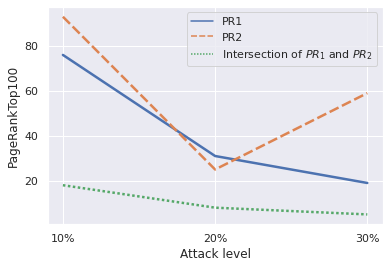

In [302]:
plot_robustness_graph(df_all_decs_robustness_pr_table,
                      df_all_decs_intersection_pr_table)

In [303]:
# Entender que valores são estes (provavelmente primeira lista é p1 e segunda é p2)
calc_qui_square_test(pd.DataFrame(np.array([[47, 29], [13, 2]])))

2.4207549283154117 0.11973721446268461 1 [[50.10989011 25.89010989]
 [ 9.89010989  5.10989011]]


**Chi squared statistic: 2.42**  
**p-value: 0.1197**

In [307]:
from pymongo import MongoClient
import sys


class Acordao:

    def __init__( self, idAcordao, tribunal, relator, virtual, similares=[], citacoes=[]):
        self.idAcordao = idAcordao
        self.tribunal = tribunal
        self.relator = relator
        self.citacoes = citacoes
        self.similares = similares
        self.virtual = virtual

    def getId( self):
        return self.idAcordao

    def getTribunal( self):
        return self.tribunal

    def getRelator( self):
        return self.relator

#     def getCitacoes( self):
#         return self.citacoes

#     def getSimilares( self):
#         return self.similares

    def getVirtual( self):
        return self.virtual

 
class GraphMaker:
    def __init__(
        self, mongo_uri, dbName, collections_in, collectionOutName,
    ):
        client = MongoClient(mongo_uri)
        self.db = client[dbName]
        self.collectionsIn = collections_in
        self.collectionOut = self.db[collectionOutName]
        self.collectionOut.drop()
        self.onePercent = sum([coll.count() for coll in self.collectionsIn]) / 100
        self.count = 0
        self.progress = 0

    def set_collections_out(self, collection_out_name):
        self.collectionOut = self.db[collection_out_name]
        self.collectionOut.drop()

    def save_removed_decisions(self, i, removed_decisions, collection_out_name):
        removed_coll = self.db[collection_out_name + "_removed_%d" % i]
        removed_coll.drop()

        removed_coll.insert_one(
            {"iteration": i, "removed_decisions": removed_decisions}
        )

    def __addElemSetToDict(self, aDict, elemKey, elemValue):
        if elemKey not in aDict:
            aDict[elemKey] = set()

        aDict[elemKey].add(elemValue)
        return aDict

    def removeInvalidAcordaosFromDicts(self, validAcordaos, quotes, quotedBy):
        """
            Remove do 'quotedBy' acórdãos que não estão presentes no BD ou nos similares apontados
            por decisões do BD. 'quotes' fica apenas com decisões citadas presentes no BD ou nos
            similares de uma determinada decisão.
        """
        for docId, quotesId in quotes.items():
            newQuotesId = set()
            for q in quotesId:
                if q in validAcordaos:
                    newQuotesId.add(q)
                else:
                    quotedBy.pop(q, 0)

            quotes[docId] = newQuotesId

        return [quotes, quotedBy]

    def buildDicts(self, query, removed_decisions, compute_similars):
        acordaos = {}
        quotes = {}
        quotedBy = {}
        similars = {}

        print("building map")

        self.count = self.progress = 0

        for coll in self.collectionsIn:
            docsFound = coll.find(query, no_cursor_timeout=True)
            for doc in docsFound:
                if doc["acordaoId"] in removed_decisions:
                    continue

                docId = doc["acordaoId"]
                for quotedId in doc["citacoesObs"]:
                    if quotedId not in removed_decisions:
                        quotes = self.__addElemSetToDict(quotes, docId, quotedId)
                        quotedBy = self.__addElemSetToDict(quotedBy, quotedId, docId)

                # similares são decisões (nós) virtuais que apontam para citacoes de 'docId'
                if compute_similars == "S":
                    for similar in doc["similares"]:
                        similarId = similar["acordaoId"]
                        if similarId not in removed_decisions:
                            for quotedId in doc["citacoesObs"]:
                                quotes = self.__addElemSetToDict(
                                    quotes, similarId, quotedId
                                )
                                quotedBy = self.__addElemSetToDict(
                                    quotedBy, quotedId, similarId
                                )

                                similars = self.__addElemSetToDict(
                                    similars, similarId, docId
                                )
                                similars = self.__addElemSetToDict(
                                    similars, docId, similarId
                                )

                            if similarId not in acordaos:
                                acordaos[similarId] = Acordao(
                                    similarId, doc["tribunal"], similar["relator"], True
                                )

                acordaos[docId] = Acordao(docId, doc["tribunal"], doc["relator"], False)
                self.__printProgress()

            print("")

        return [acordaos, quotes, quotedBy, similars]

    def insertNodes(self, acordaos, quotes, quotedBy, similars, pageRanks):
        nDocs = len(acordaos)
        self.onePercent = nDocs / 100
        self.count = self.progress = 0
        insertStep = nDocs
        if nDocs > 10000:
            insertStep = 10000

        print("n acordaos %s to be inserted" % nDocs)

        i = 0
        docs2Insert = []
        for docId, doc in acordaos.items():
            docQuotedBy = list(quotedBy.get(docId, set()))
            docQuotes = list(quotes.get(docId, set()))
            docSimilars = list(similars.get(docId, set()))
            docPageRank = float(pageRanks.get(docId, 0.0))
            docs2Insert.append(
                {
                    "acordaoId": docId,
                    "citacoes": docQuotes,
                    "citadoPor": docQuotedBy,
                    "similares": docSimilars,
                    "indegree": len(docQuotedBy),
                    "outdegree": len(docQuotes),
                    "relator": doc.getRelator(),
                    "tribunal": doc.getTribunal(),
                    "pageRank": docPageRank,
                    "virtual": doc.getVirtual(),
                }
            )
            i += 1
            self.__printProgress()
            if i >= insertStep:
                self.collectionOut.insert_one(docs2Insert)
                docs2Insert = []
                i = 0

        print("")
        if i > 0:
            self.collectionOut.insert_one(docs2Insert)

    def __printProgress(self):
        self.count += 1
        if self.count >= self.onePercent:
            self.count = 0
            self.progress += 1
            sys.stdout.write("\r%d%%" % self.progress)
            sys.stdout.flush()



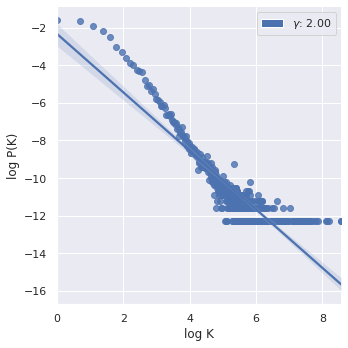

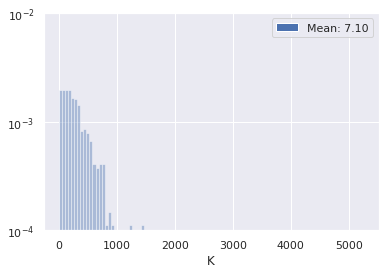

In [320]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pymongo import MongoClient
# from GraphMaker import GraphMaker


def preprocess_query(query_raw):
    query = {}
    if query_raw:
        queryPairs = query_raw.split(",")
        if not queryPairs:
            queryPairs = query_raw
        for pair in queryPairs:
            pairSplit = pair.split(":")
            field = pairSplit[0].strip()
            value = pairSplit[1].strip()
            query[field] = value
    return query


def get_decisions_ids(collections, query):
    MONGO_URI = os.getenv("MONGO_URI")
    MONGO_DATABASE = os.getenv("MONGO_DATABASE")
    client = MongoClient(MONGO_URI)
    db = client[MONGO_DATABASE]

    decisions_ids = []
    colls = []
    if collections == "acordaos":
        colls.append(db["acordaos"])
    elif collections == "decisoes_monocraticas":
        colls.append(db["decisoes_monocraticas"])
    elif collections == "decisoes":
        colls.append(db["acordaos"])
        colls.append(db["decisoes_monocraticas"])

    for coll in colls:
        docs = coll.find(query, no_cursor_timeout=True)
        for doc in docs:
            decisions_ids.append(doc["acordaoId"])
            # decisions_ids.append([doc["acordaoId"], doc["observacao"], doc["similaresTexto"]])

    return decisions_ids, colls


def run_page_rank_iteration(query, collections_name):
    decisions_ids, collections = get_decisions_ids(
         collections_name, query
    )

    MONGO_URI = os.getenv("MONGO_URI")
    MONGO_DATABASE = os.getenv("MONGO_DATABASE")
    collection_out_iter_name = "_fake_coll"
    graphMaker = GraphMaker(
        MONGO_URI,
        MONGO_DATABASE,
        collections,
        collection_out_iter_name,
    )

    removed_decisions = []
    compute_similars = "S"
    [acordaos, quotes, quotedBy, similars] = graphMaker.buildDicts(
        query, removed_decisions, compute_similars
    )
#     [quotes, quotedBy] = graphMaker.removeInvalidAcordaosFromDicts(
#         acordaos, quotes, quotedBy
#     )
    # faz grafo ficar sem direção
    new_quotes = {}
    for k, vals in quotes.items():
        if k not in new_quotes:
            new_quotes[k] = set(vals)
        elif k not in new_quotes[v]:
            new_quotes[k].update(vals)
        for v in vals:
            if v not in new_quotes:
                new_quotes[v] = set([k])
            elif k not in new_quotes[v]:
                new_quotes[v].update([k])

    return new_quotes


def create_papers_graphs(new_quotes):
    nodes_degrees = [len(v) for k, v in new_quotes.items()]
    df = pd.DataFrame(nodes_degrees, columns=["count"])
    df_counts = df["count"].value_counts().reset_index()
    df_counts = df_counts.rename(columns={"index": "K"})
    df_counts = df_counts.sort_values(by=['K'])
    N = df_counts["count"].sum()
    df_counts["P(K)"] = df_counts["count"].apply(lambda x: x/N)
    df_counts["log P(K)"] = df_counts["P(K)"].apply(lambda x: np.log(x))
    df_counts["log K"] = df_counts["K"].apply(lambda x: np.log(x))
    df_counts["log P(K) / log K"] = - df_counts["log P(K)"] / df_counts["log K"]

    ax = sns.lmplot(data=df_counts[df_counts["K"] > 0], y="log P(K)", x="log K")
    gamma = df_counts[df_counts["log K"] > 0]["log P(K) / log K"].mean()
    red_patch = mpatches.Patch(label=r"$\gamma$: {:.2f}".format(gamma))
    plt.legend(handles=[red_patch])
    plt.show()
    ax.savefig("gamma_value_log.png")

    plt.clf()
    plt.cla()
    plt.close()

#     ax = sns.distplot(df_counts["K"][df_counts["K"] > 1000], kde=False, norm_hist=True, bins=100)
    ax = sns.distplot(df_counts["K"], kde=False, norm_hist=True, bins=100)
    ax.set(yscale="log")
    ax.set(ylim=(0.0001, 0.01))
    red_patch = mpatches.Patch(label=r"Mean: {:.2f}".format(np.mean(df[df["count"] > 0]["count"])))
    plt.legend(handles=[red_patch])
    plt.show()
    ax.figure.savefig("graph_node_degrees_hist.png")


query_raw = ""
query = preprocess_query(query_raw)
new_quotes = run_page_rank_iteration(query, "acordaos")
create_papers_graphs(new_quotes)

In [ ]:
# show graph without outliers in the second graph and a barplot only for outliers

### Getting intersection of decisions between PageRank model 1 and Kleinberg top 100 measures for decisions with and without similar decisions

In [334]:
df_robustness_pr1_kl_lst = [[df_robustness_pr_lst[i][0], df_robustness_kl_lst[i][0]] for i in range(3)]
df_robustness_no_similars_pr1_kl_lst = [[df_robustness_no_similars_pr_lst[0][0], df_robustness_no_similars_kl_lst[0][0]]]
df_robustness_magistrates_pr1_kl_lst = [[df_robustness_magistrates_pr_lst[i][0], df_robustness_magistrates_kl_lst[i][0]] for i in range(10)]

df_robustness_intersect_all_decs_pr1_kl_lst = get_intersection_decisions_tabulated(
    df_robustness_pr1_kl_lst
)
df_robustness_intersect_no_similars_pr1_kl_lst = get_intersection_decisions_tabulated(
    df_robustness_no_similars_pr1_kl_lst
)
df_robustness_intersect_magistrates_pr1_kl_lst = get_intersection_decisions_tabulated(
    df_robustness_magistrates_pr1_kl_lst
)

### Building robustness tables for intersections between all PageRank model 1 and Kleinberg top 100  measures for (all decisions, top 10 magistrates, and without similar decisions)

In [336]:
df_all_decs_intersection_pr1_kl_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_all_decs_pr1_kl_lst, ["Intersect"], [10, 20, 30]
)
df_no_similars_intersect_pr1_kl_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_no_similars_pr1_kl_lst, ["Intersect"], [10]
)
df_magistrates_intersection_pr1_kl_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_magistrates_pr1_kl_lst,
    ["Intersect"],
    top_10_magistrates,
)


### Intersection of decisions between PageRank 1 model and Kleinberg results for decisions WITH similars

In [338]:
df_all_decs_intersection_pr1_kl_table.index.name = "Perturbance level (%)"
df_all_decs_intersection_pr1_kl_table

,Intersect
Perturbance level (%),
10,3
20,0
30,1


### Intersection of decisions between PageRank 1 model and Kleinberg results for decisions WITHOUT similars

In [339]:
df_no_similars_intersect_pr1_kl_table.index.name = "Perturbance level (%)"
df_no_similars_intersect_pr1_kl_table

,Intersect
Perturbance level (%),
10,4


### Intersection of decisions between PageRank 1 model and Kleinberg results for top 10 magistrates decisions

In [340]:
df_magistrates_intersection_pr1_kl_table.index.name = "Magistrate"
df_magistrates_intersection_pr1_kl_table

,Intersect
Magistrate,
MARCO AURÉLIO,11
CÁRMEN LÚCIA,1
GILMAR MENDES,2
RICARDO LEWANDOWSKI,6
DIAS TOFFOLI,2
LUIZ FUX,9
ROSA WEBER,4
ROBERTO BARROSO,0
CELSO DE MELLO,4


### Getting intersection of decisions between PageRank model 2 and Kleinberg top 100 measures for decisions with and without similar decisions

In [335]:
df_robustness_pr2_kl_lst = [[df_robustness_pr_lst[i][1], df_robustness_kl_lst[i][0]] for i in range(3)]
df_robustness_no_similars_pr2_kl_lst = [[df_robustness_no_similars_pr_lst[0][1], df_robustness_no_similars_kl_lst[0][0]]]
df_robustness_magistrates_pr2_kl_lst = [[df_robustness_magistrates_pr_lst[i][1], df_robustness_magistrates_kl_lst[i][0]] for i in range(10)]

df_robustness_intersect_all_decs_pr2_kl_lst = get_intersection_decisions_tabulated(
    df_robustness_pr2_kl_lst
)
df_robustness_intersect_no_similars_pr2_kl_lst = get_intersection_decisions_tabulated(
    df_robustness_no_similars_pr2_kl_lst
)
df_robustness_intersect_magistrates_pr2_kl_lst = get_intersection_decisions_tabulated(
    df_robustness_magistrates_pr2_kl_lst
)

### Building robustness tables for intersections between all PageRank model 2 and Kleinberg top 100  measures for (all decisions, top 10 magistrates, and without similar decisions)

In [337]:
df_all_decs_intersection_pr2_kl_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_all_decs_pr2_kl_lst, ["Intersect"], [10, 20, 30]
)
df_no_similars_intersect_pr2_kl_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_no_similars_pr2_kl_lst, ["Intersect"], [10]
)
df_magistrates_intersection_pr2_kl_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_magistrates_pr2_kl_lst,
    ["Intersect"],
    top_10_magistrates,
)


### Intersection of decisions between PageRank 1 model and Kleinberg results for decisions WITH similars

In [341]:
df_all_decs_intersection_pr2_kl_table.index.name = "Perturbance level (%)"
df_all_decs_intersection_pr2_kl_table

,Intersect
Perturbance level (%),
10,4
20,0
30,1


### Intersection of decisions between PageRank 1 model and Kleinberg results for decisions WITHOUT similars

In [342]:
df_no_similars_intersect_pr2_kl_table.index.name = "Perturbance level (%)"
df_no_similars_intersect_pr2_kl_table

,Intersect
Perturbance level (%),
10,0


### Intersection of decisions between PageRank 1 model and Kleinberg results for top 10 magistrates decisions

In [343]:
df_magistrates_intersection_pr2_kl_table.index.name = "Magistrate"
df_magistrates_intersection_pr2_kl_table

,Intersect
Magistrate,
MARCO AURÉLIO,11
CÁRMEN LÚCIA,1
GILMAR MENDES,3
RICARDO LEWANDOWSKI,6
DIAS TOFFOLI,5
LUIZ FUX,10
ROSA WEBER,5
ROBERTO BARROSO,0
CELSO DE MELLO,4


### Getting intersection between Kleinberg authority and PageRank model 1 measures (for all decisions, decisions without similars and top 10 magistrates) for FIRST ITERATION

In [358]:
df_robustness_pr1_kl_lst = [[df_all_decs_pr_lst[i][0], df_all_decs_kl_lst[i]] for i in range(3)]
df_robustness_no_similars_pr1_kl_lst = [[df_all_decs_no_similars_pr_lst[0][0], df_all_decs_no_similars_kl_lst[0]]]
df_robustness_magistrates_pr1_kl_lst = [[df_magistrates_decs_pr_lst[i][0], df_magistrates_decs_kl_lst[i]] for i in range(10)]

df_intersec_with_sim_dec_pr1_kl_lst = get_intersection_decisions_first_iter_tabulated(
    df_robustness_pr1_kl_lst
)
df_intersec_without_sim_dec_pr1_kl_lst = get_intersection_decisions_first_iter_tabulated(
    df_robustness_no_similars_pr1_kl_lst
)
df_intersec_magistrates_pr1_kl_lst = get_intersection_decisions_first_iter_tabulated(
    df_robustness_magistrates_pr1_kl_lst
)


/home/jackson/.local/share/virtualenvs/analise-juridica-SICVn6Yg/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Building robustness tables for intersections of top 100 decisions measures between Kleinberg authority and PageRank model 1 for all decisions, for top 10 magistrates, and without similar decisions IN THE FIRST ITERATION


In [360]:
df_intersec_with_sim_dec_pr1_kl_table = create_dataframe_from_list_sizes(
    df_intersec_with_sim_dec_pr1_kl_lst, ["Intersect"], [10, 20, 30]
)
df_intersec_without_sim_dec_pr1_kl_table = create_dataframe_from_list_sizes(
    df_intersec_without_sim_dec_pr1_kl_lst, ["Intersect"], [10]
)
df_intersec_magistrates_pr1_kl_table = create_dataframe_from_list_sizes(
    df_intersec_magistrates_pr1_kl_lst, ["Intersect"], top_10_magistrates
)

### Intersection of decisions between Kleinberg authority and PageRank 1 models results for all decisions WITH similars IN THE FIRST ITERATION

In [362]:
df_intersec_with_sim_dec_pr1_kl_table.index.name = "Perturbance level (%)"
df_intersec_with_sim_dec_pr1_kl_table

,Intersect
Perturbance level (%),
10,3
20,3
30,3


### Intersection of decisions between Kleinberg authority and PageRank 1 models results for all decisions WITHOUT similars IN THE FIRST ITERATION

In [363]:
df_intersec_without_sim_dec_pr1_kl_table.index.name = "Perturbance level (%)"
df_intersec_without_sim_dec_pr1_kl_table

,Intersect
Perturbance level (%),
10,4


### Intersection of decisions between Kleinberg authority and PageRank 1 models results for top 10 magistrates decisions IN THE FIRST ITERATION

In [364]:
df_intersec_magistrates_pr1_kl_table.index.name = "Magistrate"
df_intersec_magistrates_pr1_kl_table

,Intersect
Magistrate,
MARCO AURÉLIO,13
CÁRMEN LÚCIA,7
GILMAR MENDES,2
RICARDO LEWANDOWSKI,9
DIAS TOFFOLI,2
LUIZ FUX,11
ROSA WEBER,8
ROBERTO BARROSO,0
CELSO DE MELLO,4


### Getting intersection between Kleinberg authority and PageRank model 2 measures (for all decisions, decisions without similars and top 10 magistrates) for FIRST ITERATION

In [359]:
df_robustness_pr2_kl_lst = [[df_all_decs_pr_lst[i][1], df_all_decs_kl_lst[i]] for i in range(3)]
df_robustness_no_similars_pr2_kl_lst = [[df_all_decs_no_similars_pr_lst[0][1], df_all_decs_no_similars_kl_lst[0]]]
df_robustness_magistrates_pr2_kl_lst = [[df_magistrates_decs_pr_lst[i][1], df_magistrates_decs_kl_lst[i]] for i in range(10)]

df_intersec_with_sim_dec_pr2_kl_lst = get_intersection_decisions_first_iter_tabulated(
    df_robustness_pr2_kl_lst
)
df_intersec_without_sim_dec_pr2_kl_lst = get_intersection_decisions_first_iter_tabulated(
    df_robustness_no_similars_pr2_kl_lst
)
df_intersec_magistrates_pr2_kl_lst = get_intersection_decisions_first_iter_tabulated(
    df_robustness_magistrates_pr2_kl_lst
)

### Building robustness tables for intersections of top 100 decisions measures between Kleinberg authority and PageRank model 2 for all decisions, for top 10 magistrates, and without similar decisions IN THE FIRST ITERATION


In [361]:
df_intersec_with_sim_dec_pr2_kl_table = create_dataframe_from_list_sizes(
    df_intersec_with_sim_dec_pr2_kl_lst, ["Intersect"], [10, 20, 30]
)
df_intersec_without_sim_dec_pr2_kl_table = create_dataframe_from_list_sizes(
    df_intersec_without_sim_dec_pr2_kl_lst, ["Intersect"], [10]
)
df_intersec_magistrates_pr2_kl_table = create_dataframe_from_list_sizes(
    df_intersec_magistrates_pr2_kl_lst, ["Intersect"], top_10_magistrates
)

### Intersection of decisions between Kleinberg authority and PageRank 2 models results for all decisions WITH similars IN THE FIRST ITERATION

In [365]:
df_intersec_with_sim_dec_pr2_kl_table.index.name = "Perturbance level (%)"
df_intersec_with_sim_dec_pr2_kl_table

,Intersect
Perturbance level (%),
10,4
20,4
30,4


### Intersection of decisions between Kleinberg authority and PageRank 2 models results for all decisions WITHOUT similars IN THE FIRST ITERATION

In [366]:
df_intersec_without_sim_dec_pr2_kl_table.index.name = "Perturbance level (%)"
df_intersec_without_sim_dec_pr2_kl_table

,Intersect
Perturbance level (%),
10,6


### Intersection of decisions between Kleinberg authority and PageRank 1 models results for top 10 magistrates decisions IN THE FIRST ITERATION

In [367]:
df_intersec_magistrates_pr2_kl_table.index.name = "Magistrate"
df_intersec_magistrates_pr2_kl_table

,Intersect
Magistrate,
MARCO AURÉLIO,13
CÁRMEN LÚCIA,6
GILMAR MENDES,3
RICARDO LEWANDOWSKI,9
DIAS TOFFOLI,5
LUIZ FUX,11
ROSA WEBER,8
ROBERTO BARROSO,0
CELSO DE MELLO,9


## Conclusões:
- Avaliar resultados da análise de Kleinberg
- Avaliar resultados da análise de Page Rank
- Avaliar intersecção entre PageRank e Kleinberg


## Dicas de análises
- Olhar valores de PR, authority e hub para entender distribuição dos valores (se são uniformes ou crescentes)
- Olhar decaimento de robustez com maior perturbação da rede
- Verificar se algum magistrado tem uma robustez menor devido a fazer mais citações a outros magistrados
- Fazer análise matemática dos modelos PR1 e PR2 para entender a diferença entre eles
- Fazer análise matemática do Kleinberg para entender como ele se comporta
